# Boat rentals (24 hour analysis)

### Project Brief

Congratulations, you have just landed your first job as a data scientist at Nearly New Nautical! Nearly New Nautical is a website that allows users to advertise their used boats for sale. To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views. 

The product manager wants to know if you can develop a model to predict the number of views a listing will receive based on the boat's features. She would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.

In addition, she has noticed that many users never complete the introductory survey to list their boat. She suspects that it is too long and has asked you whether some features are more predictive of views than others. If so, she may be able to trim the length of the survey and increase the number of people who sign up.

You will need to present your findings in two formats:
- First, you will need to present your findings to the product manager via a 10 minute oral presentation. The owner has no technical data science background. 
- You will also need to submit a technical report to your manager, who does have a strong technical data science background.



### Introduction

Finding the perfect recipe to increase the sign-up ratio and the traffic into the website is definitely challenging. It gets even more so, if the sign-up experience is full of endless questions. This notebook was created to attempt facing these challenges. To do so, we have been provided with a dataset that is comprised of 9888 entries. Even though the dataset does not seem that big, it's extremely inconsistent which we will see under "2. Data cleaning". Here is the small description of the dataset and its columns:

<center><figure>
  <img src="data/data.png" width="500">
    <figcaption><i>Fig.1 - Dataset description.</i></figcaption>
</figure></center>


#### Table of Content
<ol>
  <li>The Dataset</li>
  <li>Data cleaning & Exploratory Data Analysis</li>
  <li>Feature selection & Model evaluation</li>
  <li>Final recommendations</li>
  <li>Future work</li>
</ol>

In [33]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [34]:
!pip install ppscore --quiet --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.22.3 which is incompatible.
tensorflow 2.4.1 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
redshift-connector 2.0.900 requires pytz<2021.9,>=2020.1, but you have pytz 2022.1 which is incompatible.
pythonwhat 2.23.1 requires dill~=0.2.7.1, but you have dill 0.3.3 which is incompatible.
pythonwhat 2.23.1 requires jinja2~=2.10, but you have jinja2 3.0.1 which is incompatible.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [35]:
# import essential packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ppscore as pps
import missingno as msno

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from utils import cleanup, viz

plt.rcParams["figure.figsize"] = (10, 5)
sns.set()
sns.set_palette('dark')

### 1. The Dataset

It's important to know what data we have in hands before diving into the most fun part - building models. To get a sense of it, we will look into the overall distribution and statistics to see whether there are any obvious problems. 

In [36]:
# read the csv file
listings = pd.read_csv('data/boat_data.csv')
listings.head(3)

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124


In [37]:
# show the shape and descriptive statistics
print('Shape of the dataset:', listings.shape)

listings.describe()

Shape of the dataset: (9888, 10)


,Year Built,Length,Width,Number of views last 7 days
count,9888.000000,9879.000000,9832.000000,9888.000000
mean,1893.192860,11.570017,3.520124,149.160801
std,460.201582,6.002820,1.220534,151.819752
min,0.000000,1.040000,0.010000,13.000000
25%,1996.000000,7.470000,2.540000,70.000000
50%,2007.000000,10.280000,3.330000,108.000000
75%,2017.000000,13.930000,4.250000,172.000000
max,2021.000000,100.000000,25.160000,3263.000000


In [38]:
# look into categorical data distributions
for col in listings.select_dtypes('object').columns:
    print(f'{col}:\n\t{listings[col].nunique()} unique values')

Price:
	3182 unique values
Boat Type:
	126 unique values
Manufacturer:
	910 unique values
Type:
	24 unique values
Material:
	11 unique values
Location:
	2995 unique values


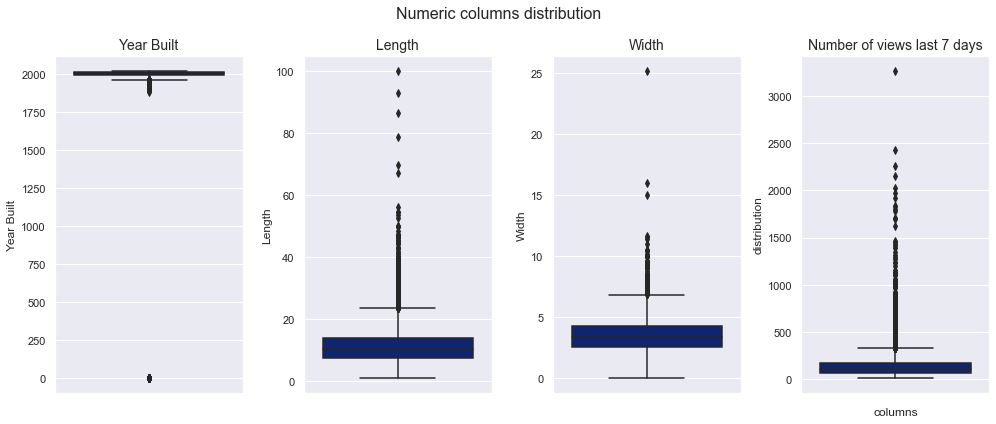

In [39]:
# look into numeric data distributions
numeric = listings.select_dtypes(np.number).columns

# show boxplots of all numeric values
fig, ax = plt.subplots(1, len(numeric), figsize=(14, 6))
# set a title
fig.suptitle('Numeric columns distribution', fontsize=16)

# traverse the dataset to show columns individually
for idx in range(len(numeric)):
    sns.boxplot(y=listings[numeric[idx]], ax=ax[idx])
    ax[idx].set_title(f'{numeric[idx]}', fontsize=14)

# label the axis and show plots
plt.xlabel('columns'); plt.ylabel('distribution')
plt.tight_layout(); plt.show()

#### 💡 Insights 

The above code revealed some important information that cannot be overlooked. First of all, the dataset is a mixture of categorical and numerical data that make up 60% and 40% respectively. However, the problem arises in the variability of such columns as *Location, Manufacturer, and Boat Type*. These columns will be carefully dealt with in the next *Data Cleaning* section. 

❗**Important**: the "Location" column contains almost 3000 unique values (!). We definitely need to carefully analyze the situation and re-map/drop insufficient data entries. Why is it important? We will build models that don't tolerate having categorical values. Therefore, we will need to convert them into numeric. That can be done with encoding (transforming categorical value to numeric) only. This will blow up the dataset's dimensions, and our dataset could end up with over 3000 columns.   

Other than that, there are the following problems that will require closer look:

- "Year Built" column has zero values, they will need to be dropped;
- "Price" column will need to undergo some alterations: cleaning, currency conversion, and homogenisation

The dataset provided is pretty messy. It will especially be more evident in the next section that specifically deals with the missing values. However, first, let's remove the "Year built" rows with 0 values!



In [40]:
# look into the rows with "Year Built" == 0
zeros = listings[listings['Year Built'] < 1900]
print(len(zeros), 'data points with "Year Built" equalling 0')

# drop insufficient data
listings.drop(index=zeros.index, axis='rows', inplace=True)

# reset index to have consistent indexing
listings.reset_index(inplace=True, drop=True)

# verify changes
assert len(listings[listings['Year Built'] < 1900]) == 0, 'There are rows with "Year Built" equalling 0'

556 data points with "Year Built" equalling 0


### 2. Data cleaning & Exploratory Data Analysis

This section deals with the numerous data cleaning techniques to make sure the data is in the same standard. We see below that the number of data rows with at least one missing value makes up ~30%. To address the situation, the action plan was created to:
1. Check the current state
2. Drop the most insignificant values 
3. Clean out the easiest column - "Boat Type"
4. Impute missing values according to Step 3 
5. Fix "Location" and "Price" columns


P.S., to keep the notebook as clean as possible, there was a need to modularize the code so that all the messy things get dealt with behind the scenes. However, because there was a rigid time constraint - there is no documentation present. 


In [41]:
# check the number of missing values
missing = listings[listings.isna().any(axis=1)]
print(f'Number of rows with missing values: {len(missing)} ({round((len(missing) / len(listings)) * 100, 2)}%)')

# check where the data is missing
missing = listings.isna().sum().reset_index().rename(columns={'index': 'column', 0: 'count'})

# show in the descending order => most missing first
missing['percentage'] = round(missing['count'] / len(listings), 2)
missing.sort_values('percentage', ascending=False)

Number of rows with missing values: 2743 (29.39%)


,column,count,percentage
7,Material,1662,0.18
2,Manufacturer,1281,0.14
6,Width,55,0.01
0,Price,0,0.00
1,Boat Type,0,0.00
3,Type,5,0.00
4,Year Built,0,0.00
5,Length,9,0.00
8,Location,36,0.00
9,Number of views last 7 days,0,0.00


In [42]:
# drop all insignificant columns that have less than 1% of missing values
listings.drop(listings[listings['Location'].isna()].index, axis='rows', inplace=True)
listings.drop(listings[listings['Width'].isna()].index, axis='rows', inplace=True)
listings.drop(listings[listings['Length'].isna()].index, axis='rows', inplace=True)
listings.drop(listings[listings['Type'].isna()].index, axis='rows', inplace=True)

# reset index 
listings.reset_index(drop=True, inplace=True)

#### Boat Types

The necessity to focus on cleaning the boat type arose from the non-homogenuous representation. There was a big number of rows with more than one boat type, i.e. "Classic, Runabout, Sport Boat" or "Cabin Boat, Motor Yacht". Figure 2 perfectly illustrates the condition of the column before cleaning. Doing so helped reduce boat types from 125 to 26!

<center><figure>
  <img src="data/boat.png" width="1000">
    <figcaption><i>Fig.2 - Boat type distribution.</i></figcaption>
</figure></center>


In [43]:
def prettify_types(x):
    """This function fixes Boat Type column"""
    for boat in BOAT_TYPES:
        if boat in x:
            return boat
    if ',' in x:
        return x.split(',')[0]
    return x

# get the most common boat types
BOAT_TYPES = listings['Boat Type'].value_counts().head(10).reset_index()['index'].tolist()

# record the number of boat types before cleaning
print('Number of unique boat types before cleaning:', listings['Boat Type'].nunique())

# clean the column and show the results
listings['Boat Type'] = listings['Boat Type'].apply(lambda x: prettify_types(x))
print('Number of unique boat types after cleaning:', listings['Boat Type'].nunique())

Number of unique boat types before cleaning: 125
Number of unique boat types after cleaning: 26


In [44]:
# fix all other missing values
cleanup.clean_group(listings)

# verify all columns are imputed
listings.isna().sum()

Price                          0
Boat Type                      0
Manufacturer                   0
Type                           0
Year Built                     0
Length                         0
Width                          0
Material                       0
Location                       0
Number of views last 7 days    0
dtype: int64

#### ❗ Important

Now that we have all the columns cleaned and no missing value present, we come across an interesting finding. The dataset includes both **used, new, and display models**. The goal of the notebook is to predict well on the used boats, so it's important to stick to it. This means dropping around 2000 data entries. 


In [45]:
# show the number of data entries before the drop
print('Number of data entries before drop:', len(listings))

# drop unimportant values and reset indices 
idx = listings[listings['Type'].str.contains('new|Display')].index
listings.drop(index=idx, axis='rows', inplace=True)
listings.reset_index(inplace=True, drop=True)

# show the number of data entries after the drop
print('Number of data entries after drop: ', len(listings))

Number of data entries before drop: 9236
Number of data entries after drop:  7232


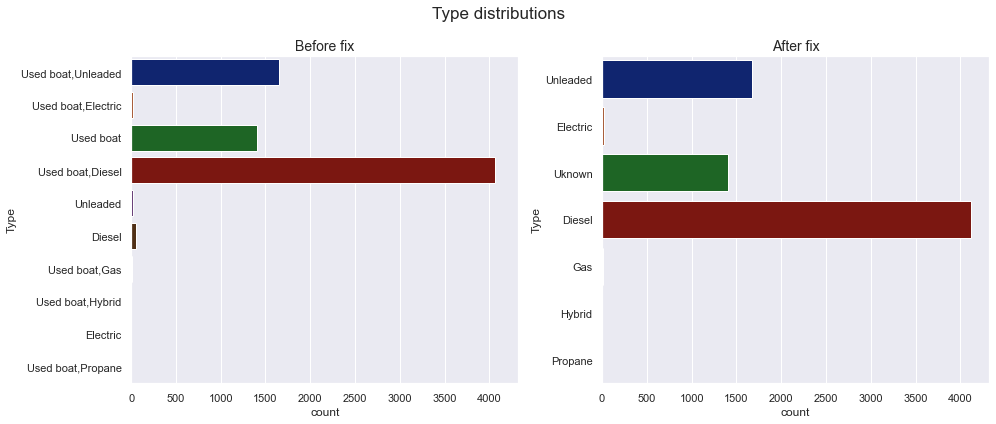

In [46]:
# clean "type" column to have only relevant information
before = listings['Type']
listings['Type'] = listings['Type'].apply(lambda x: cleanup.change_type(x))

# visually show the difference
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
sns.countplot(y=before, ax=ax[0])
sns.countplot(y=listings['Type'], ax=ax[1])

# set titles
ax[0].set_title('Before fix', fontsize=14)
ax[1].set_title('After fix', fontsize=14)

# set the main title and label axis
fig.suptitle('Type distributions', fontsize=17)
plt.xlabel('count')
plt.ylabel('Type')

plt.tight_layout()
plt.show()

#### Fix small problems 

Now that we have everything in the same format, we can fix the final details. There are a lot of columns that have singular occurrence. Since they don't provide any meaningful information to the model, it's best to drop them. To illustrate why I'm doing that, here's the sorted from top-bottom and bottom-top to show the difference:

<figure>
    <center>
        <img src="data/types.png" width=400 height=500/>
        <figcaption><i>Fig.3 - Boat type percentage distribution.</i></figcaption>
    </center>
    
</figure>


In [47]:
# remove insignificant data from "Boat Type" column
types = listings['Boat Type'].value_counts(normalize=True).reset_index()
index = types[types['Boat Type'] < 0.01]['index'].tolist()

# drop values that take up less than 1% of the dataset
listings.drop(index=listings[listings['Boat Type'].isin(index)].index, axis='rows', inplace=True)
listings.reset_index(inplace=True, drop=True)

In [48]:
# remove insignificant data from "Material" column
types = listings['Material'].value_counts(normalize=True).reset_index()
index = types[types['Material'] < 0.009]['index'].tolist()

# drop values that take up less than 9% of the dataset
listings.drop(index=listings[listings['Material'].isin(index)].index, axis='rows', inplace=True)
listings.reset_index(inplace=True, drop=True)

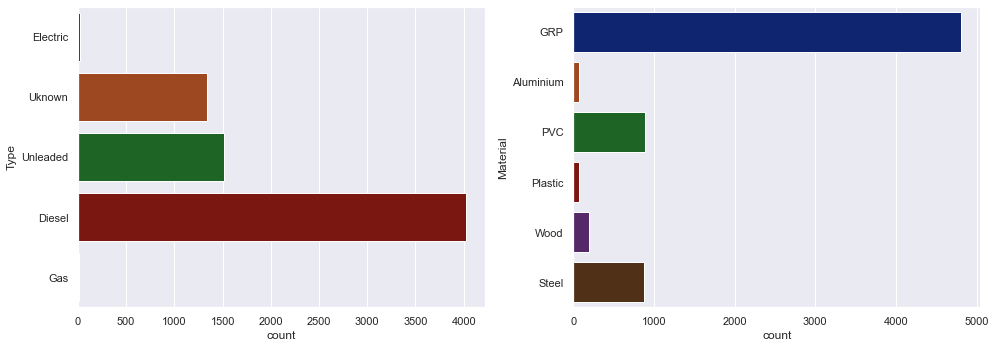

In [49]:
# show the current distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(y=listings['Type'], ax=ax[0])
sns.countplot(y=listings['Material'], ax=ax[1]) 
plt.tight_layout()
plt.show()

#### Location column

In [50]:
# fix location column
listings['Location'] = listings['Location'].apply(lambda x: cleanup.prettify_locations(x))

In [51]:
# select countries to not delete
safe = ['Romania', 'Egypt', 'Taiwan', 'Luxembourg', 'Ireland', 'Morocco', 'Seychelles', 'Gibraltar', 'Lebanon', 'Serbia']
countries = listings['Location'].value_counts().reset_index()

# delete single-instance data entries
delete = countries[(countries['Location'] < 2) & (~countries['index'].isin(safe))]['index'].tolist()
idx = listings[listings['Location'].isin(delete)].index
listings.drop(index=idx, axis='rows', inplace=True)
listings.reset_index(drop=True, inplace=True)

In [52]:
# group countries that have less than 6% representation
types = listings['Location'].value_counts(normalize=True).reset_index()
countries = types[types['Location'] < 0.06]['index'].tolist()

# change the Location value
index = listings[listings['Location'].isin(countries)].index
listings.loc[index, 'Location'] = 'Other'

#### Price Column

Here we will remove currency from the "Price" column and put everything in Euro because it's the most common currency.

In [53]:
def replace_money(x):
    if 'EUR' in x or 'CHF' in x or 'DKK' in x:
        return x
    else:
        return 'GBP'

# separate the currency
listings['Currency'] = listings['Price'].apply(lambda x: replace_money(x.split(' ')[0]))

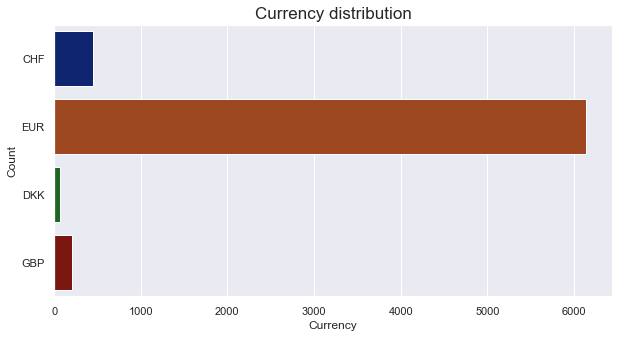

In [54]:
# show the most common currency
sns.countplot(data=listings, y='Currency')
plt.title('Currency distribution', fontsize=17)
plt.xlabel('Currency'); plt.ylabel('Count')
plt.show()

In [55]:
# remove currency from price and convert the data type
listings['Price'] = listings['Price'].apply(lambda x: x.split(' ')[-1])
listings['Price'] = listings['Price'].astype('int32')
listings.head(3)

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days,Currency
0,3500,Fishing Boat,Terhi power boats,Electric,1987,4.35,1.75,GRP,Switzerland,239,CHF
1,3500,Sport Boat,GS Nautica power boats,Uknown,2004,4.70,2.00,GRP,Italy,69,EUR
2,4500,Fishing Boat,Italmarine power boats,Unleaded,1997,3.72,1.33,Aluminium,Switzerland,413,CHF


In [56]:
def convert_money(x):
    if x['Currency'] == 'CHF':
        return x['Price'] * 0.97
    if x['Currency'] == 'GBP':
        return x['Price'] * 1.18
    if x['Currency'] == 'DKK':
        return x['Price'] * 0.13
    return x['Price']

# traverse the column to put everything in EURO
for idx, content in listings.iterrows():
    listings.loc[idx, 'Price'] = convert_money(content)

# remove the unnecessary column
listings.drop('Currency', axis='columns', inplace=True)

#### 📖 Summary 

This section was the heaviest for a reason. There were a lot of categorical values that needed careful analysis. Overall, with such big effort we were able to reduce the categorical values drastically. Here's the table to illustrate the dramatic effect:

| Column | Before (unique values) | After (unique values) |
| --- | --- | --- |
| Boat Type | 126 | 14 |
| Manufacturer | 910 | 742 | 
| Type | 24 | 4 | 
| Material | 11 | 6 |
| Location | 2995 | 8 | 



### 3. Feature Selection & Model Evaluation

To see how data is related to each other, we typically use Correlation Matrix. However, our case requires something more powerful. Since Correlation Matrix can only work with numeric data, we need a tool that can reveal some insights about the categorical values! Therefore, I'm using a Power Score Matrix instead [1]. It's much more powerful in many ways, so we will stick to it. Now hidden data can no longer hide!

Below we see some interesting insights:
- Length & Width are correlated which is not surprising. We will need to drop one of them, I'll be removing the "Width" column. 
- Manufacturer column has big correlations with "Material", "Boat Type", and "Location" columns. We will also remove this column because of two reasons: multi-collinearity and big number of unique values (over 700). 
- No column seem to have correlation with our goal - "Number of views last 7 days". 


#### Model 
Since the dataset has quite a lot of outliers and a big number of categorical data, the best model to use would be **RandomForestRegressor**. It performed better in both time- and accuracy evaluations in comparison to Adaboost and XGBoost. Last two models didn't score better than 25%. I will talk about the results of the final model at the end of the block. 

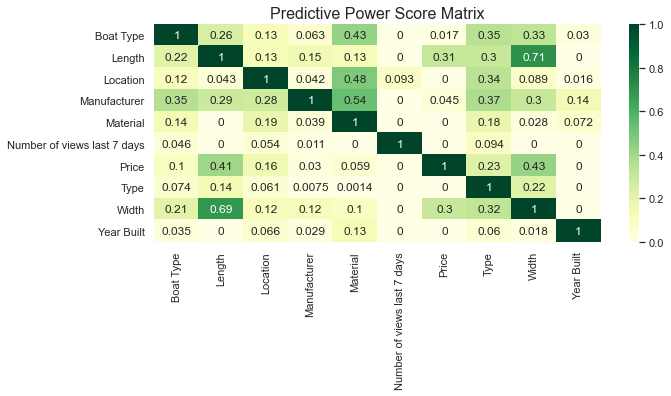

In [57]:
# visualize power score matrix
viz.pps_matrix(listings)

In [58]:
# drop "Width" column
listings.drop('Width', axis='columns', inplace=True)

# drop Manufacturer column
listings.drop('Manufacturer', axis='columns', inplace=True)

#### Split data and train

In [59]:
# split data
X, y = listings.drop('Number of views last 7 days', axis='columns'), listings['Number of views last 7 days']

# encode categorical values
X = pd.get_dummies(X, drop_first=True)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

In [60]:
# instantiate the model
reg = RandomForestRegressor(max_features='sqrt', min_samples_leaf=7, n_estimators=200).fit(X_train, y_train)

# predict test values
preds = reg.predict(X_test)

# show RMSE score
print('RMSE score:', np.sqrt(mean_squared_error(y_test, preds)))

RMSE score: 120.23500253795163


### How many values are predicted with 50% of the true value?

Since the goal of the notebook was to predict as close to the true value as possible and there was an acceptable margin of error, we can use that information to calculate how many data points fall into that category. 

Below we can see that out of 1536 values, 1034 of them indeed fall into that distribution. This accounts for 67% of data to be more-or-less correctly classified!

In [61]:
# calculate the number of appropriate predictions
preds_df = pd.DataFrame({'true': y_test, 'pred': preds})
preds_df['diff'] = preds_df['true'] - preds_df['pred']
preds_df['off'] = np.abs(preds_df['diff']) > (preds_df['true'] // 2)

# show results
preds_df['off'].value_counts()

False    1083
True      632
Name: off, dtype: int64

### What features play the biggest part?

One more task was to analyze whether there was a need to shorten the number of questions when posting an ad. Indeed, there **is** a need to do so. It turned out that the most important features are: Location, Price, Length & Width, Year Built. Other features don't play that big of a role. 

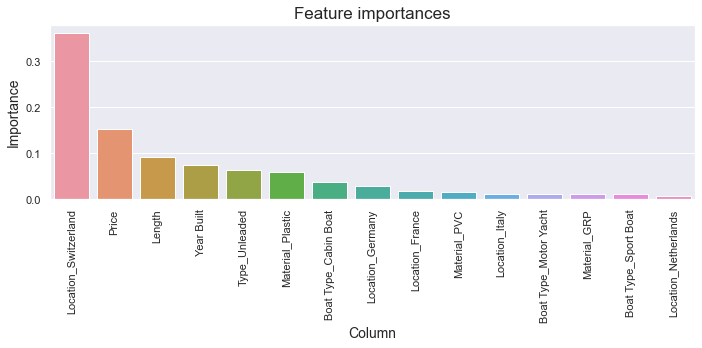

In [62]:
# get and sort feature importances
importances = pd.DataFrame(reg.feature_importances_, index=X.columns).rename(columns={0: 'importance'})
sort = importances.sort_values('importance', ascending=False).reset_index().head(15)

# visualize the first 15 values
sns.barplot(np.arange(0, len(sort)), sort['importance'])
plt.title('Feature importances', fontsize=17)
plt.xticks(np.arange(0, len(sort)), sort['index'], rotation=90)
plt.xlabel('Column', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.tight_layout()
plt.show()

### Which boats have the lowest number of views?

One final task that the managers wanted us to perform was to see which boats have the lowest number of views. According to the true data, the boat class that gets the lowest reviews are Center Console Boats (99) Deck Boats (102). However, the model predicted them higher. The two classes that receive the lowest number of views according to the model are House Boats (212-true, 174-predicted) and Mega Yacht (192-true, 177-predicted). 

In [69]:
# look into the boats with lowest views predicted
df = listings.copy()
df['preds'] = reg.predict(X)
df['diff'] = df['Number of views last 7 days'] - df['preds']

df.groupby('Boat Type').agg({'Number of views last 7 days': np.mean,
                             'preds': np.mean})

,Number of views last 7 days,preds
Boat Type,,
Bowrider,205.174419,195.074820
Cabin Boat,278.493298,261.399535
Center console boat,99.881720,122.315448
Classic,259.841667,261.893388
Deck Boat,102.790476,135.998412
Fishing Boat,170.114943,214.965910
Flybridge,107.003591,108.125754
Hardtop,119.088670,113.534675
House Boat,212.421687,174.105450


### 4. Final Recommendations

1. Fewer questions <br>
As seen above, not all the questions were used in the analysis. The two columns that initially had the biggest number of missing values in (Materials=18% and Manufacturer=14%) turned out to be insignificant. Therefore, to increase the signing-up ratio, we would generally need Location, Price, Length & Width, Year Built information. 

2. More thorough analysis & better model <br>
It's quite logical to suggest spending more time analyzing the dataset to see more patterns. Having had only 24 hours to submit a complete analysis implies that it was rushed and some important points might be overlooked. Therefore, to know for a fact which moves to take next, it's strongly recommended to further analyze the dataset. The possible vectors are discussed next in the "Future Work" section. 

3. Look into the boats with lowest views more in details <br>
The analysis provided here gives food for thought for the upcoming analysis. It's interesting how the most expensive boat - Mega Yacht and Houseboat got less views than anticipated. It might be helpful to analyze the data entries further.


4. Improved UX and UI <br>
While cleaning the dataset, there was a lot of inconsistency present. One big improvement would be to have a drop-down to select a specific category so that there is no bad data introduced.



### 5. Future Work

To make the analysis better and more accurate, there will be a need to look into the Location distributions to see if there are any patterns. I believe there should be more "boat-friendly" locations where having a boat is a must! Just in general, going back and diving into the dataset is always a good idea to find any new patterns. 

Next, to see which questions would increase the sign-up ratio, it would be great to run several statistical tests such as A/B. 

Moreover, find the dimensionality techniques and models that are suited for datasets with a big number of categorical data.
